# 关键词搜索（进阶版）

Kaggle竞赛题：https://www.kaggle.com/c/home-depot-product-search-relevance

鉴于课件里已经完整的show了NLTK在各个NLP处理上的用法，我这里就不再重复使用了。

本篇的教程里会尽量用点不一样的库，让大家感受一下Python NLP领域各个库的优缺点。

同时，

在进阶版故事中，我们将讨论除了一些显而易见的“自制feature”之外，更加牛x的算法：

- String Distance

- TF-iDF

- Word2Vec（具体原理会在下堂课继续）

注意，前面的预处理部分维持不变（懒得折腾。。预处理这事儿 要玩儿可以玩儿一年。。）

## Step1：导入所需

所有要用到的库

In [69]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

读入训练/测试集

In [70]:
df_train = pd.read_csv('../input/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('../input/test.csv', encoding="ISO-8859-1")

这里还有个有用的玩意儿，叫产品介绍

In [71]:
df_desc = pd.read_csv('../input/product_descriptions.csv')

看看数据们都长什么样子

In [72]:
df_train.head()

id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance  
0       angle bracket       3.00  
1           l bracket       2.50  
2           deck over       3.00  
3    rain shower head       2.33  
4  shower only faucet       2.67

In [73]:
df_desc.head()

product_uid                                product_description
0       100001  Not only do angles make joints stronger, they ...
1       100002  BEHR Premium Textured DECKOVER is an innovativ...
2       100003  Classic architecture meets contemporary design...
3       100004  The Grape Solar 265-Watt Polycrystalline PV So...
4       100005  Update your bathroom with the Delta Vero Singl...

看来不要做太多的复杂处理，我们于是直接合并测试/训练集，以便于统一做进一步的文本预处理

In [74]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [75]:
df_all.head()

id                                      product_title  product_uid  \
0   2                  Simpson Strong-Tie 12-Gauge Angle       100001   
1   3                  Simpson Strong-Tie 12-Gauge Angle       100001   
2   9  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...       100002   
3  16  Delta Vero 1-Handle Shower Only Faucet Trim Ki...       100005   
4  17  Delta Vero 1-Handle Shower Only Faucet Trim Ki...       100005   

   relevance         search_term  
0       3.00       angle bracket  
1       2.50           l bracket  
2       3.00           deck over  
3       2.33    rain shower head  
4       2.67  shower only faucet

合并之后我们得到:

In [76]:
df_all.shape

(240760, 5)

产品介绍也是一个极有用的信息，我们把它拿过来：

In [77]:
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')

In [78]:
df_all.head()

id                                      product_title  product_uid  \
0   2                  Simpson Strong-Tie 12-Gauge Angle       100001   
1   3                  Simpson Strong-Tie 12-Gauge Angle       100001   
2   9  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...       100002   
3  16  Delta Vero 1-Handle Shower Only Faucet Trim Ki...       100005   
4  17  Delta Vero 1-Handle Shower Only Faucet Trim Ki...       100005   

   relevance         search_term  \
0       3.00       angle bracket   
1       2.50           l bracket   
2       3.00           deck over   
3       2.33    rain shower head   
4       2.67  shower only faucet   

                                 product_description  
0  Not only do angles make joints stronger, they ...  
1  Not only do angles make joints stronger, they ...  
2  BEHR Premium Textured DECKOVER is an innovativ...  
3  Update your bathroom with the Delta Vero Singl...  
4  Update your bathroom with the Delta Vero Singl...

好了，现在我们得到一个全体的数据大表格

## Step 2: 文本预处理

我们这里遇到的文本预处理比较简单，因为最主要的就是看关键词是否会被包含。

所以我们统一化我们的文本内容，以达到任何term在我们的数据集中只有一种表达式的效果。

我们这里用简单的Stem做个例子：

（有兴趣的同学可以选用各种你觉得靠谱的预处理方式：去掉停止词，纠正拼写，去掉数字，去掉各种emoji，等等）

In [79]:
stemmer = SnowballStemmer('english')

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

为了计算『关键词』的有效性，我们可以naive地直接看『出现了多少次』

In [80]:
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

接下来，把每一个column都跑一遍，以清洁所有的文本内容

In [81]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))

In [82]:
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

In [83]:
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

## Step 3: 进阶版文本特征

这里我们讨论几个有点逼格的文本特征算法：

#### Levenshtein

使用Levenshtein很直观，直接调用python标准库即可

In [84]:
import Levenshtein

Levenshtein.ratio('hello', 'hello world')

0.625

好的，接下来我们把search_term和product_title进行比较：

In [85]:
df_all['dist_in_title'] = df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_title']), axis=1)

同理，对产品介绍进行比较：

In [86]:
df_all['dist_in_desc'] = df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_description']), axis=1)

#### TF-iDF

TF-iDF稍微复杂点儿，因为它涉及到一个需要提前把所有文本计算统计一下的过程。

我们首先搞一个新的column，叫all_texts, 里面是所有的texts。（我并没有算上search term, 因为他们不是一个结构完整的句子，可能会影响tfidf的学习）。为了防止句子格式不完整，我们也强制给他们加上句号。

*注意：这里我们最严谨的做法是把train/test先分开，然后只在train上做tfidf的学习，并在test上直接转化。然而由于我不想把整个文章顺序打乱（因为本来train/test分开的步骤在最后），因为我希望大家看的时候可以跟简单版教程有很好的结构对照，所以我直接tfidf用在全部的语料集上。如果想安慰自己的话，你可以这么考虑：我们的算法虽然看到了test的文本内容，但是没有test的label。可以姑且认为test的文本内容本身也就是可见的。并且，这种行为在kaggle的竞赛中并没有被禁止，很多竞赛的kernel提交算法都有这问题，所以我们姑且先不care。但是我个人非常不赞同这么做。同学们如果自己在线下做实验的时候，希望可以做到严谨。不要cheating哦~*

In [87]:
df_all['all_texts']=df_all['product_title'] + ' . ' + df_all['product_description'] + ' . '

搞完之后，长这样：

In [88]:
df_all['all_texts'][:5]

0    simpson strong-ti 12-gaug angl . not onli do a...
1    simpson strong-ti 12-gaug angl . not onli do a...
2    behr premium textur deckov 1-gal. #sc-141 tugb...
3    delta vero 1-handl shower onli faucet trim kit...
4    delta vero 1-handl shower onli faucet trim kit...
Name: all_texts, dtype: object

然后，我们取出所有的单字，做成一个我们的单词字典：（这里我们用gensim，为了更加细致的分解TFIDF的步骤动作；其实sklearn本身也有简单好用的tfidf模型，详情见第二课stock news基本版教程）

Tokenize可以用各家或者各种方法，就是把长长的string变成list of tokens。包括NLTK，SKLEARN都有自家的解决方案。或者你自己直接用str自带的split()方法，也是一种tokenize。只要记住，你这里用什么，那么之后你的文本处理都得用什么。

In [89]:
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(list(tokenize(x, errors='ignore')) for x in df_all['all_texts'].values)
print(dictionary)

Dictionary(221877 unique tokens: ['fontain', 'extrusion', 'shiftingbreak', 'unfold', 'fibersdesign']...)


楼上可见，我们得到了221877个单词的大词典。我们以此准备出一个语料库。
因为语料库一般都很大，所以我建议我们做语料的时候都用个iterator来实现。

于是我们写一个类(class)：

这个类所做的事情也很简单，就是扫便我们所有的预料，并且转化成简单的单词的个数计算。（Bag-of-Words）

In [90]:
class MyCorpus(object):
    def __iter__(self):
        for x in df_all['all_texts'].values:
            yield dictionary.doc2bow(list(tokenize(x, errors='ignore')))

# 这里这么折腾一下，仅仅是为了内存friendly。面对大量corpus数据时，你直接存成一个list，会使得整个运行变得很慢。
# 所以我们搞成这样，一次只输出一组。但本质上依旧长得跟 [['sentence', '1'], ['sentence', '2'], ...]一样

corpus = MyCorpus()

有了我们标准形式的语料库，我们于是就可以init我们的TFIDFmodel了。

这里做的事情，就是把已经变成BoW向量的数组，做一次TFIDF的计算。详情参见课件。

In [91]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus)

好，这下我们看看一个普通的句子放过来长什么样子：

In [92]:
tfidf[dictionary.doc2bow(list(tokenize('hello world, good morning', errors='ignore')))]

[(985, 0.2947139124944075),
 (3430, 0.28760732706613895),
 (33767, 0.6587176730120703),
 (35249, 0.6296957697663794)]

怎么判断两个句子的相似度呢？

这里有个trick，因为我们得到的tfidf只是『有这个字，就有这个值』，并不是一个全部值。

也就是说，两个matrix可能size是完全不一样的。

想用cosine计算的同学就会问了，两个matrix的size都不fix，怎么办？

咦，这里就注意咯。他们的size其实是一样的。只是把全部是0的那部分给省略了对吧？

于是，我们只要拿其中一个作为index。扩展开全部的matrixsize，另一个带入，就可以计算了。

In [93]:
from gensim.similarities import MatrixSimilarity

# 先把刚刚那句话包装成一个方法
def to_tfidf(text):
    res = tfidf[dictionary.doc2bow(list(tokenize(text, errors='ignore')))]
    return res

# 然后，我们创造一个cosine similarity的比较方法
def cos_sim(text1, text2):
    tfidf1 = to_tfidf(text1)
    tfidf2 = to_tfidf(text2)
    index = MatrixSimilarity([tfidf1],num_features=len(dictionary))
    sim = index[tfidf2]
    # 本来sim输出是一个array，我们不需要一个array来表示，
    # 所以我们直接cast成一个float
    return float(sim[0])

来，我们可以做个测试：

In [94]:
text1 = 'hello world'
text2 = 'hello from the other side'
cos_sim(text1, text2)

0.8566456437110901

好，万事俱备，我们现在就只需要把我们的column都转化成tfidf计算出来的相似度了：

因为sim的结果是一个np array，所以我们用'[0]'取里面那个唯一值就行了

In [95]:
df_all['tfidf_cos_sim_in_title'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_title']), axis=1)

我们来看看长什么样子：

In [96]:
df_all['tfidf_cos_sim_in_title'][:5]

0    0.274539
1    0.000000
2    0.000000
3    0.133577
4    0.397320
Name: tfidf_cos_sim_in_title, dtype: float64

同理，

In [97]:
df_all['tfidf_cos_sim_in_desc'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_description']), axis=1)

至此，我们又有了两个高质量的features。

#### Word2Vec

最后，我们的大杀器w2v登场了。

最好的情况呢，其实是你在另一个地方用非常大非常完备的语料库做好w2v的training，再跑到这个任务上来直接输出vector。具体可以参照官网上谷歌新闻语料的一个大大的w2v模型。可下载，以后用。

我们这里，用个轻量级的解决方案，那就是直接在我们的文本上学习。（跟tfidf玩法差不多）

然而，w2v和tfidf有个很大的不同。对于tfidf而言，只需要知道一整段text中包含了哪些word元素就行了。其他都不用care。

但是w2v要考虑到句子层级的split，以及语境前后的考虑。

所以，刚刚tfidf的corpus不能直接被这里使用。在这里，我们需要把句子/文字都给分类好。

这里，我们再玩儿一个NLP的杀器：NLTK。

In [98]:
import nltk
# nltk也是自带一个强大的句子分割器。
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

我们看看效果

In [99]:
tokenizer.tokenize(df_all['all_texts'].values[0])

['simpson strong-ti 12-gaug angl .',
 'not onli do angl make joint stronger, they also provid more consistent, straight corners.',
 'simpson strong-ti offer a wide varieti of angl in various size and thick to handl light-duti job or project where a structur connect is needed.',
 'some can be bent (skewed) to match the project.',
 'for outdoor project or those where moistur is present, use our zmax zinc-coat connectors, which provid extra resist against corros (look for a "z" at the end of the model number).versatil connector for various 90 connect and home repair projectsstrong than angl nail or screw fasten alonehelp ensur joint are consist straight and strongdimensions: 3 in.',
 'x 3 in.',
 'x 1-1/2 in.mad from 12-gaug steelgalvan for extra corros resistanceinstal with 10d common nail or #9 x 1-1/2 in.',
 'strong-driv sd screw . ']

依照这个方法，我们先把长文本搞成list of 句子，再把句子变成list of 单词：

In [100]:
sentences = [tokenizer.tokenize(x) for x in df_all['all_texts'].values]

其实这些sentences不需要这些层级关系，他们都是平级的，所以：

我们把list of lists 给 flatten了。

In [101]:
sentences = [y for x in sentences for y in x]

这下我们可以看到，一共1998321个句子。

In [102]:
len(sentences)

1998321

接着，我们把句子里的单词给分好。这事儿我们还是可以用刚刚Gensim的tokenizer

这里我们用nltk的word_tokenizer来试试

In [103]:
from nltk.tokenize import word_tokenize
w2v_corpus = [word_tokenize(x) for x in sentences]

好，这下我们训练model

In [104]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(w2v_corpus, size=128, window=5, min_count=5, workers=4)

这时候，每个单词都可以像查找字典一样，读出他们的w2v坐标了：

In [105]:
model['right']

array([ 4.74717617,  2.64686418,  0.35502195,  0.80881947, -2.7076602 ,
       -1.64652073, -2.27783561, -0.92420739, -0.14867701,  5.74324369,
       -0.7946381 ,  4.2346034 ,  0.85286433,  2.52050495, -0.73137748,
        1.9509604 , -1.75785506, -0.81137753,  1.03638244, -1.19456983,
       -0.23727451, -2.1338408 , -0.28541893, -2.99906659, -3.9443922 ,
        3.45797253, -1.05518758,  2.46135116, -2.20839262, -1.80382502,
        4.74548674,  1.45839429,  1.89756656, -0.03712106,  1.1392957 ,
       -0.28602245, -0.8830694 , -0.23989263,  1.52211082, -3.42239022,
        0.01539903,  0.87455851,  0.25244436, -1.04864109, -2.5990386 ,
       -0.72978145,  3.70196033,  1.23104656,  1.96894944,  0.28224495,
       -2.56046462, -1.574512  , -2.20811892,  2.57060266, -2.39487839,
       -2.57700634,  2.41890597,  0.75820315, -2.01431084, -2.13502717,
       -0.1664609 , -0.10223585, -0.93037611,  4.34696054, -0.88387358,
       -4.04143572, -0.76093572, -4.64342451,  5.51188993,  1.15

跟TFiDF一样，我们可以把textual的column都转化为w2v坐标

这里不一样的是，TFiDF是针对每个句子都可以有的，而w2v是针对每个单词的。

所以我们要有个综合考虑的idea：

平均化一个句子的w2v向量，算作整个text的平均vector：

我们写一个方法来实现：

In [106]:
# 先拿到全部的vocabulary
vocab = model.vocab

# 得到任意text的vector
def get_vector(text):
    # 建立一个全是0的array
    res =np.zeros([128])
    count = 0
    for word in word_tokenize(text):
        if word in vocab:
            res += model[word]
            count += 1
    return res/count            

我们可以试试：

In [107]:
print(get_vector('life is like a box of chocolate'))

[ 0.463416    0.97560888  0.10863534 -0.82696981  1.41277812  0.79170082
  0.0978372  -0.68150822  0.99790255 -0.44159976  1.00841724 -0.43905148
  0.21946578  1.01400004 -1.97788476 -0.24557593 -1.13167921 -0.22579467
 -0.48376473  0.41615273  0.67180802  0.53008292  0.52145608 -1.9788011
  1.42492926 -0.18045649 -0.65986957 -0.93241019  1.1279408   0.06740171
  0.40830285  0.79715398 -0.84070924  0.35409186  0.29476608 -0.01593437
 -0.2836557  -0.27918024  1.09351952 -0.34930461  2.4379538   0.60693575
 -0.42956293  1.8092562  -0.43648594 -0.58754889 -1.25327353 -0.65632194
  1.29220566  0.52857347  0.08685846  0.04752858 -0.59915119 -0.00281862
 -0.99020389 -0.82765476  0.16989418  1.01381083 -0.0428756   0.98613351
 -1.3658159  -1.43513804 -0.75343464 -0.09422477  0.07967508 -0.87333807
  0.36081878 -0.81233797  0.2529      1.28962335  1.31695796 -1.45198588
  1.3620293   0.11232918 -0.21050634 -0.27940779 -0.13681145 -1.03338094
  0.07509582  0.46833945  0.00504241  1.29592314  0.

好，同理，我们需要计算两个text的平均w2v的cosine similarity

In [108]:
from scipy import spatial
# 这里，我们再玩儿个新的方法，用scipy的spatial

def w2v_cos_sim(text1, text2):
    try:
        w2v1 = get_vector(text1)
        w2v2 = get_vector(text2)
        sim = 1 - spatial.distance.cosine(w2v1, w2v2)
        return float(sim)
    except:
        return float(0)
# 这里加个try exception，以防我们得到的vector是个[0,0,0,...]

In [109]:
w2v_cos_sim('hello world', 'hello from the other side')

0.2397940355621142

跟刚刚TFIDF一样，我们计算一下search term在product title和product description中的cosine similarity

In [110]:
df_all['w2v_cos_sim_in_title'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_title']), axis=1)
df_all['w2v_cos_sim_in_desc'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_description']), axis=1)

In [111]:
df_all.head(5)

id                                      product_title  product_uid  \
0   2                     simpson strong-ti 12-gaug angl       100001   
1   3                     simpson strong-ti 12-gaug angl       100001   
2   9  behr premium textur deckov 1-gal. #sc-141 tugb...       100002   
3  16  delta vero 1-handl shower onli faucet trim kit...       100005   
4  17  delta vero 1-handl shower onli faucet trim kit...       100005   

   relevance         search_term  \
0       3.00        angl bracket   
1       2.50           l bracket   
2       3.00           deck over   
3       2.33    rain shower head   
4       2.67  shower onli faucet   

                                 product_description  dist_in_title  \
0  not onli do angl make joint stronger, they als...       0.190476   
1  not onli do angl make joint stronger, they als...       0.153846   
2  behr premium textur deckov is an innov solid c...       0.175000   
3  updat your bathroom with the delta vero single...       0.326087   
4  updat your bathroom with the delta vero single...       0.382979   

   dist_in_desc                                          all_texts  \
0      0.030418  simpson strong-ti 12-gaug angl . not onli do a...   
1      0.022901  simpson strong-ti 12-gaug angl . not onli do a...   
2      0.017875  behr premium textur deckov 1-gal. #sc-141 tugb...   
3      0.048632  delta vero 1-handl shower onli faucet trim kit...   
4      0.054545  delta vero 1-handl shower onli faucet trim kit...   

   tfidf_cos_sim_in_title  tfidf_cos_sim_in_desc  w2v_cos_sim_in_title  \
0                0.274539               0.182836              0.482381   
1                0.000000               0.000000              0.322772   
2                0.000000               0.053455              0.307271   
3                0.133577               0.043712              0.532707   
4                0.397320               0.098485              0.726722   

   w2v_cos_sim_in_desc  
0             0.425223  
1             0.110944  
2             0.445303  
3             0.465209  
4             0.486046

搞完之后，我们把不能被『机器学习模型』处理的column给drop掉

In [112]:
df_all = df_all.drop(['search_term','product_title','product_description','all_texts'],axis=1)

## Step 4: 重塑训练/测试集

舒淇说得好，要把之前脱下的衣服再一件件穿回来

数据处理也是如此，搞完一圈预处理之后，我们让数据重回原本的样貌

#### 分开训练和测试集

In [113]:
df_train = df_all.loc[df_train.index]
df_test = df_all.loc[df_test.index]

#### 记录下测试集的id

留着上传的时候 能对的上号

In [114]:
test_ids = df_test['id']

#### 分离出y_train

In [115]:
y_train = df_train['relevance'].values

#### 把原集中的label给删去

否则就是cheating了

In [116]:
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

## Step 5: 建立模型

我们用个最简单的模型：

In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

用CV结果保证公正客观性；并调试不同的alpha值

In [118]:
params = [1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

画个图来看看：

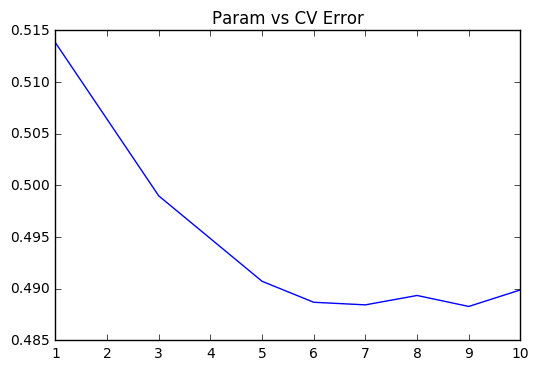

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error");

大概9的时候达到了最优解。直观的来看 可能跟前文的差别不大。

但是同学们可以试试其他不同的算法，就可以对比出差距了。

## Step 6: 上传结果

用我们测试出的最优解建立模型，并跑跑测试集

In [120]:
rf = RandomForestRegressor(n_estimators=30, max_depth=6)

In [121]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [122]:
y_pred = rf.predict(X_test)

把拿到的结果，放进PD，做成CSV上传：

In [123]:
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('submission.csv',index=False)

## 总结：

这一篇教程中，用了稍微复杂的方法教大家加入更多高质量的features。

同学们可以尝试修改/调试/升级的部分是：

2. **更多的特征**: Deep Learning的大重点就是黑盒机制。所以，其实我们刚刚得到的tfidf或者w2v vector可以就不做任何处理塞进我们的X里面去。然后我们使用更加深度的学习模型来训练它。这样，我们的算法可以“看见”更加原始的信息。假设他们比人脑好的话，他们就可以作出更好的predictions。

3. **更好的回归模型**: 根据之前的课讲的Ensemble方法，把分类器提升到极致